# About this notebook

**This notebook provides several experiments, that allow us to compare Pyro implementation of SVI and our implementation from the article <!!!!>. **

In [1]:
# general libraries
import os
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

# torch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.nn import Parameter
from torch.autograd import Variable
import torch.distributions.constraints as constraints



# Pyro libraries
import pyro
from pyro.optim import Adam
from pyro.infer import SVI as Pyro_SVI, Trace_ELBO
import pyro.distributions as dist

# Our SVI functions
from BBSVI import SVI as Our_SVI
from BBSVI import HistoryCollector

# Generating Data

In [2]:
mu = 2.5
np.random.seed(42)
num_samples = 1000
data = torch.Tensor(np.random.normal(mu, 1., size=num_samples))

# Our models

In [3]:
class Prior:
    def __init__(self):
        self.prior = torch.distributions.Normal(torch.zeros(1), torch.ones(1))
        
    def log_likelihood_global(self, beta):
        return self.prior.log_prob(beta)
    
    def log_likelihood_joint(self, x, z, beta):
        cond = torch.distributions.Normal(beta, torch.ones(1))
        return cond.log_prob(x)
    
    def log_likelihood_cond(self, x, z, beta):
        cond = torch.distributions.Normal(beta, torch.ones(1))
        return cond.log_prob(x)

In [4]:
class VariationalDistribution:
    def __init__(self):
        self.mu = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.sigma = nn.Parameter(torch.ones(1), requires_grad=True)
        self.distr = torch.distributions.Normal(self.mu, self.sigma)
        self.parameters = [self.mu, self.sigma]
        
    def sample_global(self):
        return self.distr.rsample()
    
    def sample_local(self, beta, idx):
        return None
    
    def entropy(self):
        return self.distr.entropy()

In [5]:
def kl(var, prior):
    return torch.distributions.kl_divergence(var.distr, prior.prior)

# Our SVI Inference

In [6]:
analytical_mu = torch.sum(data) / (1 + num_samples)
analytical_sigma = np.sqrt(1 / (1 + num_samples))

In [7]:
prior = Prior()
var = VariationalDistribution()
opt = torch.optim.Adam(var.parameters, lr=1e-3)
our_svi = Our_SVI(data, prior, var, opt)

In [8]:
history_collector = HistoryCollector(data.shape[0])

foo = history_collector.collect_history

In [9]:
num_steps = 50
discounter_schedule = torch.Tensor(np.linspace(0, 1, num_steps))

print('Prior params:                \t mu=%.2f \t sigma=%.2f' % (var.mu, var.sigma))

start_time = time.time()
our_svi.make_inference(num_steps=num_steps, num_samples=1, loss='entropy', print_progress=True, 
                       discounter_schedule=None, callback = foo)

svi_time = time.time() - start_time

print('VI Posterior params:         \t mu=%.2f \t sigma=%.2f' % (var.mu, var.sigma))
print('Analytical Posterior params: \t mu=%.2f \t sigma=%.2f' % (analytical_mu, analytical_sigma))
print("Number of steps: ", num_steps, " Time: ", svi_time)

Prior params:                	 mu=0.00 	 sigma=1.00
..................................................
VI Posterior params:         	 mu=2.48 	 sigma=0.05
Analytical Posterior params: 	 mu=2.52 	 sigma=0.03
Number of steps:  50  Time:  5.597148895263672


# Pyro models

In [10]:
def model(data):
    
    # define the hyperparameters that control the Normal prior
    mu0 = torch.tensor(0.)
    sigma0 = torch.tensor(1.)
    
    # sample f from the Normal prior
    f = pyro.sample("latent_variable", dist.Normal(mu0, sigma0))
    
    # loop over the observed data
    for i in range(len(data)):
        
        # observe datapoint i using the Normal
        # likelihood Normal(f, 1)
        
        pyro.sample("obs_{}".format(i), dist.Normal(f, torch.tensor(1.)), obs=data[i])


In [11]:
def guide(data):
    
    # register the two variational parameters with Pyro
    # - mu parameter will have initial value 0
    # - sigma parameter will have initial value 1
    # - because we invoke constraints.positive, the optimizer
    # will take gradients on the unconstrained parameters
    # (which are related to the constrained parameters by a log)
    
    mu_q = pyro.param("mu_q", torch.tensor(0.))
    
    sigma_q = pyro.param("sigma_q", torch.tensor(1.),
                        constraint=constraints.positive)
    
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_variable", dist.Normal(mu_q, sigma_q))

# Pyro SVI inference

In [12]:
# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
n_steps = 2 if smoke_test else 50

# enable validation (e.g. validate parameters of distributions)
pyro.enable_validation(True)

# clear the param store in case
pyro.clear_param_store()

In [13]:
# setup the optimizer
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
pyro_svi = Pyro_SVI(model, guide, optimizer, loss=Trace_ELBO())


pyro_loss_history = []


start_time = time.time()

# do gradient steps
for step in range(num_steps):
        
    cur_loss = pyro_svi.step(data)

    pyro_loss_history.append(cur_loss)
    
    if step % 100 == 0:
        print('.', end='')

pyro_time = time.time() - start_time

# grab the learned variational parameters
mu_q = pyro.param("mu_q").item()
sigma_q = pyro.param("sigma_q").item()


print('VI Posterior params:         \t mu=%.2f \t sigma=%.2f' % (mu_q, sigma_q))
print('Analytical Posterior params: \t mu=%.2f \t sigma=%.2f' % (analytical_mu, analytical_sigma))
print("Number of steps: ", num_steps, " Time: ", pyro_time)

.VI Posterior params:         	 mu=0.05 	 sigma=1.00
Analytical Posterior params: 	 mu=2.52 	 sigma=0.03
Number of steps:  50  Time:  7.692559719085693


# Plotting

In [14]:
def plot_losses(our_loss, pyro_loss, our_time, pyro_time, num_steps = 50):
    

    fig = plt.figure(figsize = (12, 12))

    ax = fig.add_subplot(111, xlabel = "time", ylabel = "loss", title = "Pyro and Our SVI comparison")
    
    ax.plot(np.linspace(0, our_time,  num_steps), our_loss, label = "Our Loss")
    ax.plot(np.linspace(0, pyro_time,  num_steps), pyro_loss, label = "Pyro Loss")
    
    ax.set_title("Pyro and Our SVI comparison", size = 20)
    ax.set_xlabel("Time", size = 20)
    ax.set_ylabel("Loss", size = 20)
    
    ax.legend()
    
    plt.show()

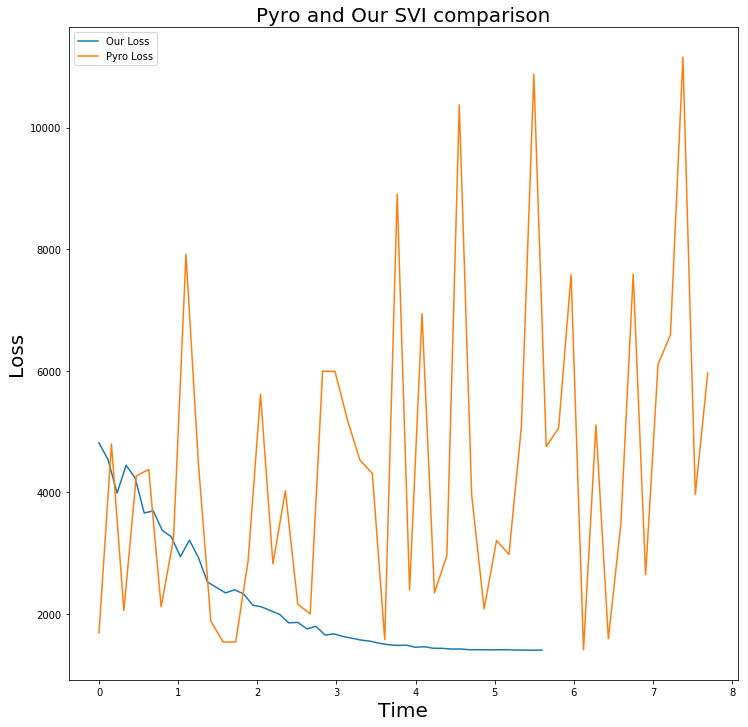

In [15]:
plot_losses(history_collector.history, pyro_loss_history, svi_time, pyro_time)